Building ResNet from scratch. Then add Dense layer to recognize blood cell images

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, \
                                    ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import seaborn as sns

In [ ]:
# turn on acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
IMAGE_SIZE = [224, 224]
epochs = 16
batch_size = 128

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

--2022-07-06 16:29:15--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  1.16MB/s    in 2m 37s  

2022-07-06 16:31:53 (681 KB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [ ]:
! unzip -nq blood_cell_images.zip

In [ ]:
! ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [ ]:
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [ ]:
folders = glob(train_path + '/*')

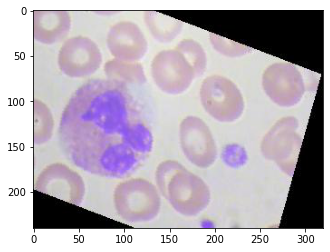

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## ResNet pieces to put together

In [ ]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1,1))(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1))(x)
  x = BatchNormalization()(x)
  x = add([x, input_])      # adding original input to convolved image
  x = Activation('relu')(x)

  return x

In [ ]:
def conv_block(input_, kernel_size, filters, strides=(2,2)):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1,1), strides=strides)(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1))(x)
  x = BatchNormalization()(x)

  shortcut = Conv2D(f3, (1,1), strides=strides)(input_) # additional input branch, but with no relu
  shortcut = BatchNormalization()(shortcut)

  x = add([x, shortcut])
  x = Activation('relu')(x)
  return x

## ResNet Architecture

In [ ]:
i = Input(shape=IMAGE_SIZE + [3])

x = ZeroPadding2D(padding=(3,3))(i)
x = Conv2D(64, (7,7), strides=(2,2), padding='valid')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1,1))(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1,1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

add our network on top of ResNet

In [ ]:
x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=i, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

Data augmentation with ImageDataGenerator and loaded dataset of blood cells

In [ ]:
def preprocess_input2(x):
  return x/127.5 - 1.

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

In [ ]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v]=k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -1.0 max: 1.0


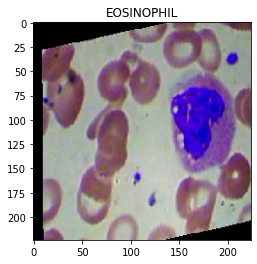

In [ ]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(            # stop when not improving
                   monitor='loss', patience=3, restore_best_weights=True
               ),
               tf.keras.callbacks.ModelCheckpoint(          # model will be saved when improved
                   filepath=checkpoint_filepath,
                   save_weights_only=True,
                   monitor='val_accuracy',
                   mode='max',
                   save_best_only=True
               )
    ]
)

Epoch 1/16
77/77 [==============================] - 168s 2s/step - loss: 10.2545 - accuracy: 0.2830 - val_loss: 1.4224 - val_accuracy: 0.2253
Epoch 2/16
77/77 [==============================] - 151s 2s/step - loss: 1.9488 - accuracy: 0.4324 - val_loss: 1.6846 - val_accuracy: 0.2529
Epoch 3/16
77/77 [==============================] - 153s 2s/step - loss: 1.2023 - accuracy: 0.6196 - val_loss: 3.3373 - val_accuracy: 0.3035
Epoch 4/16
77/77 [==============================] - 137s 2s/step - loss: 0.8176 - accuracy: 0.7506 - val_loss: 4.3987 - val_accuracy: 0.3590
Epoch 5/16
77/77 [==============================] - 138s 2s/step - loss: 0.4684 - accuracy: 0.8506 - val_loss: 10.3235 - val_accuracy: 0.3335
Epoch 6/16
77/77 [==============================] - 138s 2s/step - loss: 0.3336 - accuracy: 0.9021 - val_loss: 8.9092 - val_accuracy: 0.3553
Epoch 7/16
77/77 [==============================] - 139s 2s/step - loss: 0.4272 - accuracy: 0.8993 - val_loss: 2.6316 - val_accuracy: 0.7319
Epoch 8/16


### Results

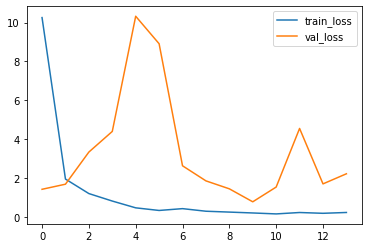

In [ ]:
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

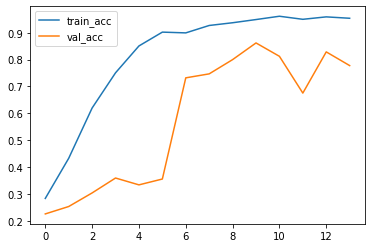

In [ ]:
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x,y in val_gen.flow_from_directory(
                                            data_path, 
                                            target_size=IMAGE_SIZE, 
                                            shuffle=False, 
                                            batch_size=batch_size*2):
        i += 1
        if i%50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    
    cm = confusion_matrix(targets, predictions)
    return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
[[2349    4    5  139]
 [   3 2463    0   17]
 [   0   16 2455    7]
 [ 123   38    8 2330]]


In [ ]:
np.trace(cm) / cm.sum()

0.9638445314853872

In [ ]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[525   3   0  95]
 [  0 613   7   0]
 [ 41   0 475 104]
 [ 65  11  15 533]]


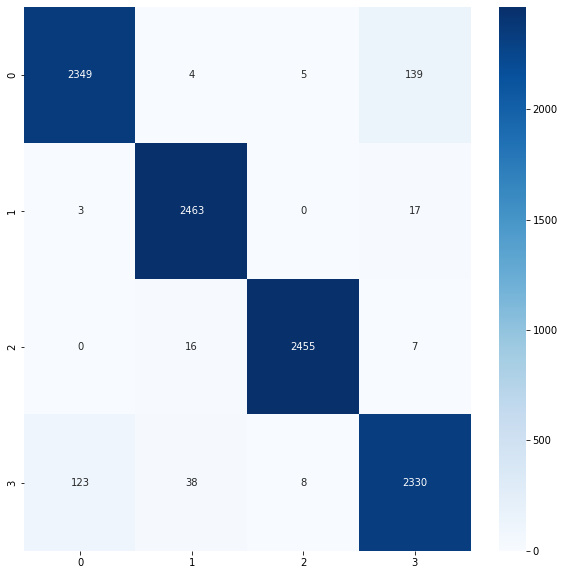

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,annot=True,fmt="g", cmap='Blues')

In [ ]:
np.trace(valid_cm) / valid_cm.sum()

0.862887012464817